In [1]:
# %%
import sys
import torch
sys.path.append('..')
# sys.path.append('/system/user/beck/pwbeck/projects/regularization/ml_utilities')
from pathlib import Path
from typing import Union
from ml_utilities.torch_models.base_model import BaseModel
from ml_utilities.torch_models import get_model_class
from omegaconf import OmegaConf

from erank.utils import load_directions_matrix_from_task_sweep
import matplotlib.pyplot as plt
gpu_id = 0

/system/apps/userenv/beck/erank/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Load matrix

In [2]:
p = '/system/user/beck/pwbeck/projects/regularization/erank/outputs/f_mnist-2.0-taskidxXXX_260622_110634/outputs'
dir_matrix = load_directions_matrix_from_task_sweep(p, device=gpu_id)
dir_matrix.requires_grad_(True)

Loading /system/user/beck/pwbeck/projects/regularization/erank/outputs/f_mnist-2.0-taskidxXXX_260622_110634/outputs/f_mnist-2.0-taskidx3-seed0_260622_110648: 100%|██████████| 10/10 [00:04<00:00,  2.21it/s]


tensor([[-0.0005, -0.0005, -0.0004,  ..., -0.0032,  0.0077, -0.0123],
        [-0.0044, -0.0045, -0.0043,  ..., -0.0023,  0.0065, -0.0126],
        [-0.0035, -0.0035, -0.0034,  ...,  0.0005,  0.0075, -0.0096],
        ...,
        [-0.0034, -0.0034, -0.0034,  ..., -0.0009,  0.0030, -0.0107],
        [-0.0011, -0.0011, -0.0012,  ..., -0.0041,  0.0075, -0.0082],
        [-0.0046, -0.0046, -0.0050,  ..., -0.0013,  0.0027, -0.0132]],
       device='cuda:0', requires_grad=True)

In [3]:
dir_matrix.shape, dir_matrix.device, dir_matrix.requires_grad

(torch.Size([10, 669706]), device(type='cuda', index=0), True)

## erank function

In [4]:
def erank(matrix_A: torch.Tensor, center_matrix_A: bool=False) -> torch.Tensor:
        """Calculates the effective rank of a matrix.

        Args:
            matrix_A (torch.Tensor): Matrix of shape m x n. 
            center_matrix_A (bool): Center the matrix 

        Returns:
            torch.Tensor: Effective rank of matrix_A
        """
        assert matrix_A.ndim == 2
        _, s, _ = torch.pca_lowrank(matrix_A, center=center_matrix_A, niter=1, q=min(matrix_A.shape[0], matrix_A.shape[1]))
        # s = torch.square(s) / (s.shape[0] - 1)

        # normalizes input s -> scale independent!
        return torch.exp(torch.distributions.Categorical(s).entropy())

In [5]:
er = erank(dir_matrix)
er

tensor(9.1032, device='cuda:0', grad_fn=<ExpBackward>)

In [6]:
# er.backward()

## What happens to the effective rank of the directions matrix, if we normalize the matrix?

The effective rank changes barely. 
Reason: The vectors in the matrix have about the same norm.

In [7]:
norm_dir_matrix = dir_matrix / torch.linalg.norm(dir_matrix, ord=2, dim=1, keepdim=True)

In [8]:
# torch.linalg.norm(dir_matrix, ord=2, dim=1, keepdim=True), torch.linalg.norm(norm_dir_matrix, ord=2, dim=1, keepdim=True)

(tensor([[11.7831],
         [ 9.9273],
         [12.0242],
         [11.0410],
         [11.1749],
         [11.7312],
         [10.3839],
         [10.7438],
         [12.8635],
         [11.3913]], device='cuda:0', grad_fn=<CopyBackwards>),
 tensor([[1.0000],
         [1.0000],
         [1.0000],
         [1.0000],
         [1.0000],
         [1.0000],
         [1.0000],
         [1.0000],
         [1.0000],
         [1.0000]], device='cuda:0', grad_fn=<CopyBackwards>))

In [9]:
erank(dir_matrix), erank(norm_dir_matrix)

(tensor(9.1032, device='cuda:0', grad_fn=<ExpBackward>),
 tensor(9.1280, device='cuda:0', grad_fn=<ExpBackward>))

## How sensitive is the erank to changes in the update vector? Specifically, the norm:

Here the erank and the singular values of the matrix = cat([pretrain_diffs, [norm_vec, 0,0, ...]]) is calculated.

Conclusion: The effective rank is highly dependent on the norms of the vectors in the directions matrix, i.e. the effective rank more influenced by vectors with larger norms (i.e. longer vectors). 

When the vectors have about the same norm, the effective rank is close to the "real rank".

This needs to be considered in construction of the erank matrix!

If we want to constrain the update directions to directions of pretrained models the update vector should have about the same norm as the pretrain_diffs. 
However, the norm of the pretraindiffs vectors is much larger, since they were updated by many gradient descent steps. 


In [10]:
norm_update_vec = 10

delta = torch.zeros(size=(1,dir_matrix.shape[1])).to(dir_matrix)
delta[0] = norm_update_vec
matrix1 = torch.cat([delta, dir_matrix], dim=0)
_, s, _ = torch.svd_lowrank(matrix1)
s, erank(matrix1)

(tensor([8.1837e+03, 2.5215e+01, 9.5973e+00, 8.8524e+00, 8.6677e+00, 8.0577e+00],
        device='cuda:0', grad_fn=<SvdHelperBackward>),
 tensor(1.0975, device='cuda:0', grad_fn=<ExpBackward>))

In [11]:
norm_update_vec = 1e-3

delta = torch.zeros(size=(1,dir_matrix.shape[1])).to(dir_matrix)
delta[0] = norm_update_vec
matrix1 = torch.cat([delta, dir_matrix], dim=0)
_, s, _ = torch.svd_lowrank(matrix1)
s, erank(matrix1)

(tensor([25.2210,  9.6167,  8.9520,  8.7838,  8.2919,  8.0398], device='cuda:0',
        grad_fn=<SvdHelperBackward>),
 tensor(9.3705, device='cuda:0', grad_fn=<ExpBackward>))

The erank is sensitive to length of update vectors.

In [12]:
# This generates values for erank plots.
# It analyzes the erank of a matrix if the norm of one vector is increased.

# I use the directions matrix (i.e. concatenated models) and concatenate one vector which has only one entry. 
# This vector spans a one-dimensional space (a line). The value of this entry is increased.

def erank_sv_norm_update_vector_sweep(dir_matrix, normalize_dir_matrix: bool = False, xlim_logscale=[-4,1], n_points=20):
    erank_vals = []
    singular_vals = []
    vec_norms = torch.logspace(xlim_logscale[0], xlim_logscale[1], n_points)
    for n in vec_norms:
        delta = torch.zeros(size=(1, dir_matrix.shape[1])).to(dir_matrix)
        delta[0] = n
        matrix1 = torch.cat([delta, dir_matrix], dim=0)
        if normalize_dir_matrix:
            # normalize matrix
            matrix1 = matrix1 / torch.linalg.norm(matrix1, ord=2, dim=1, keepdim=True)
        erank_vals.append(erank(matrix1).item())
        _, s, _ = torch.svd_lowrank(matrix1)
        singular_vals.append(s.detach().cpu().numpy())
    return vec_norms, erank_vals, singular_vals


In [13]:
# make plot erank vs. appended vector norm
# def erank_vs_update_step_norm(dir_matrix, vals=20)
vec_norms, erank_vals, singular_vals = erank_sv_norm_update_vector_sweep(dir_matrix, normalize_dir_matrix=False)

(5, 60)

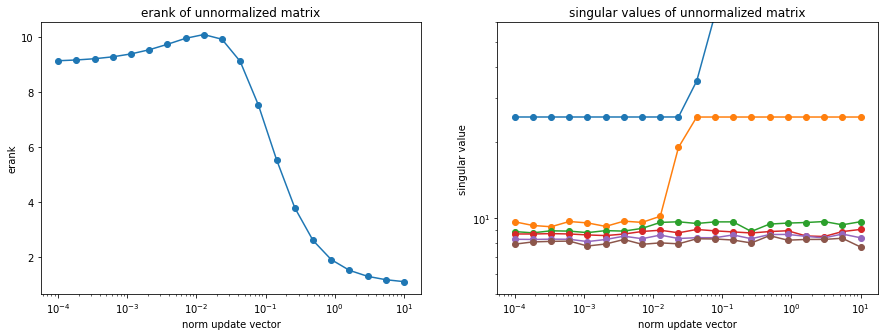

In [14]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(vec_norms, erank_vals, 'o-')
plt.xscale('log')
plt.ylabel('erank')
plt.xlabel('norm update vector')
plt.title('erank of unnormalized matrix')

plt.subplot(1,2,2)
plt.plot(vec_norms, singular_vals, 'o-')
plt.xscale('log')
plt.yscale('log')
plt.ylabel('singular value')
plt.xlabel('norm update vector')
plt.title('singular values of unnormalized matrix')
plt.ylim(5, 60)

In [15]:
# make same plot of normalized matrix
vec_norms, erank_vals, singular_vals = erank_sv_norm_update_vector_sweep(dir_matrix, normalize_dir_matrix=True)

Text(0.5, 1.0, 'singular values of normalized matrix')

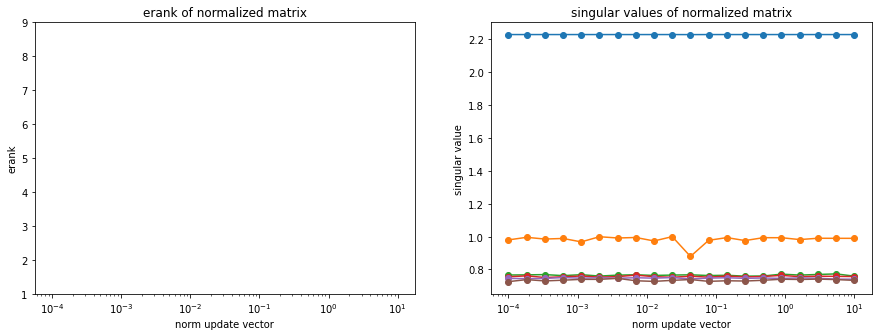

In [16]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(vec_norms, erank_vals, 'o-')
plt.xscale('log')
plt.ylim(1,9)
plt.ylabel('erank')
plt.xlabel('norm update vector')
plt.title('erank of normalized matrix')

plt.subplot(1,2,2)
plt.plot(vec_norms, singular_vals, 'o-')
plt.xscale('log')
plt.ylabel('singular value')
plt.xlabel('norm update vector')
plt.title('singular values of normalized matrix')


## Same analysis with unit direction matrix

This is just a sanity check if we observe the same behavior as above in a controlled setting. 

dir_matrix = cat([identity, [norm_vec,0,0,...]])

In [17]:
diag = torch.eye(10)
vec_norms, erank_vals, singular_vals = erank_sv_norm_update_vector_sweep(diag, normalize_dir_matrix=False)

(0.0, 3.0)

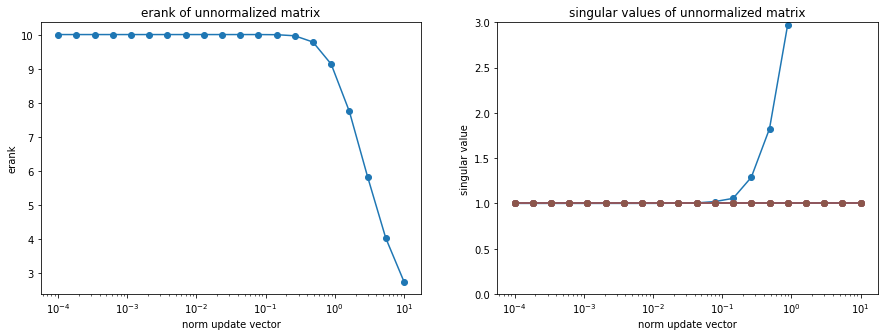

In [18]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(vec_norms, erank_vals, 'o-')
plt.xscale('log')
plt.ylabel('erank')
plt.xlabel('norm update vector')
plt.title('erank of unnormalized matrix')

plt.subplot(1,2,2)
plt.plot(vec_norms, singular_vals, 'o-')
plt.xscale('log')
# plt.yscale('log')
plt.ylabel('singular value')
plt.xlabel('norm update vector')
plt.title('singular values of unnormalized matrix')
plt.ylim(0, 3)

In [19]:
diag = torch.eye(10)
vec_norms, erank_vals, singular_vals = erank_sv_norm_update_vector_sweep(diag, normalize_dir_matrix=True)

Text(0.5, 1.0, 'singular values of normalized matrix')

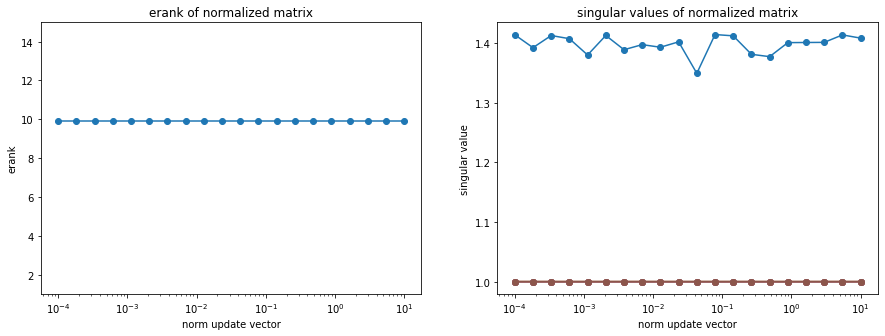

In [20]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(vec_norms, erank_vals, 'o-')
plt.xscale('log')
plt.ylim(1,15)
plt.ylabel('erank')
plt.xlabel('norm update vector')
plt.title('erank of normalized matrix')

plt.subplot(1,2,2)
plt.plot(vec_norms, singular_vals, 'o-')
plt.xscale('log')
plt.ylabel('singular value')
plt.xlabel('norm update vector')
plt.title('singular values of normalized matrix')

In [21]:
# Effective rank of a diagonal matrix:
erank(diag)

tensor(10.0000)

## Problem description

The 